In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

from sklearn.base import BaseEstimator, TransformerMixin

import os


In [3]:
# Load the CSV
df = pd.read_csv('dataset_vehicles.csv')

# Shuffle it
df = df.sample(frac=1, random_state=42)
df.reset_index(drop=True, inplace=True)


In [4]:
# The dimensions
df.shape


(18938, 19)

In [5]:
# The columns, their datatypes and whether there are nulls
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18938 entries, 0 to 18937
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Title           18938 non-null  object
 1   Sub_title       18938 non-null  object
 2   Price           18938 non-null  object
 3   Brand           18938 non-null  object
 4   Model           18938 non-null  object
 5   Edition         13908 non-null  object
 6   Year            18938 non-null  int64 
 7   Condition       18938 non-null  object
 8   Transmission    18938 non-null  object
 9   Body            17043 non-null  object
 10  Fuel            18938 non-null  object
 11  Capacity        18938 non-null  object
 12  Mileage         18938 non-null  object
 13  Location        18938 non-null  object
 14  Description     18938 non-null  object
 15  Post_URL        18938 non-null  object
 16  Seller_name     18938 non-null  object
 17  Seller_type     18938 non-null  object
 18  publis

In [6]:
# Have a look at the data

df.head(3)


,Title,Sub_title,Price,Brand,Model,Edition,Year,Condition,Transmission,Body,Fuel,Capacity,Mileage,Location,Description,Post_URL,Seller_name,Seller_type,published_date
0,Suzuki Wagon R Stingray Petrol 2017 for sale,"Posted on 09 Apr 5:46 pm, Angoda, Colombo","Rs 4,150,000",Suzuki,Wagon R Stingray,Petrol,2017,Used,Automatic,Hatchback,Petrol,600 cc,"32,000 km","Angoda, Colombo","Ist owner, single use car, used for Colombo ru...",https://ikman.lk/en/ad/suzuki-wagon-r-stingray...,J Dadallage,Premium-Member,2021-04-09 17:46:00
1,Mitsubishi Lancer Box 1979 for sale,"Posted on 13 Apr 1:18 pm, Colombo 10, Colombo","Rs 535,000",Mitsubishi,Lancer,Box,1979,Used,Manual,Saloon,Petrol,"1,400 cc","250,000 km","Colombo 10, Colombo",ORIGINAL BOOKð 5 FORWORDð ALLOY WHEELâ...,https://ikman.lk/en/ad/mitsubishi-lancer-box-1...,dinuka,Premium-Member,2021-04-13 13:18:00
2,Toyota Raize 2020 Z for sale,"Posted on 22 Jul 3:45 pm, Kandy, Kandy","Rs 10,100,000",Toyota,Raize,Toyota Raize 2020 Z,2020,Used,Automatic,SUV / 4x4,Petrol,"1,000 cc","13,000 km","Kandy, Kandy",Toyota Raize Z Grade Fully Loaded 2020Vehicle ...,https://ikman.lk/en/ad/toyota-raize-2020-z-for...,Varuna Abeygunawardene,Premium-Member,2021-07-22 15:45:00


In [7]:
# Clean Price: remove "Rs", spaces, commas
def clean_price(price_str):
    if pd.isna(price_str):
        return np.nan
    price_clean = str(price_str).replace('Rs', '').replace(' ', '').replace(',', '').strip()
    try:
        return float(price_clean)
    except:
        return np.nan

df['Price_clean'] = df['Price'].apply(clean_price)

df['Price_clean'].describe()


count    1.893800e+04
mean     6.419971e+06
std      8.597758e+06
min      9.900000e+02
25%      2.250000e+06
50%      3.990000e+06
75%      6.895000e+06
max      2.100000e+08
Name: Price_clean, dtype: float64

In [8]:
# Clean Mileage: remove "km", commas, spaces
def clean_mileage(mileage_str):
    if pd.isna(mileage_str):
        return np.nan
    mileage_clean = str(mileage_str).lower().replace('km', '').replace(',', '').replace(' ', '').strip()
    try:
        return float(mileage_clean)
    except:
        return np.nan

df['Mileage_clean'] = df['Mileage'].apply(clean_mileage)

df['Mileage_clean'].describe()


count      18938.000000
mean       96146.181329
std        76426.996513
min            0.000000
25%        45200.000000
50%        83000.000000
75%       130000.000000
max      1000000.000000
Name: Mileage_clean, dtype: float64

In [9]:
# Clean Capacity: remove "cc", commas, spaces
def clean_capacity(capacity_str):
    if pd.isna(capacity_str):
        return np.nan
    capacity_clean = str(capacity_str).lower().replace('cc', '').replace(',', '').replace(' ', '').strip()
    try:
        return float(capacity_clean)
    except:
        return np.nan

df['Capacity_clean'] = df['Capacity'].apply(clean_capacity)

df['Capacity_clean'].describe()


count    18938.000000
mean      1507.833457
std        738.664631
min          1.000000
25%       1000.000000
50%       1490.000000
75%       1800.000000
max      10000.000000
Name: Capacity_clean, dtype: float64

In [10]:
# Remove rows where price is missing (can't do supervised learning without target!)
df_clean = df[df['Price_clean'].notna()].copy()

# Remove dodgy years
df_clean = df_clean[(df_clean['Year'] >= 1950) & (df_clean['Year'] <= 2026)]

# Remove extreme outliers using IQR
Q1 = df_clean['Price_clean'].quantile(0.25)
Q3 = df_clean['Price_clean'].quantile(0.75)
IQR = Q3 - Q1
df_clean = df_clean[(df_clean['Price_clean'] >= Q1 - 3*IQR) & (df_clean['Price_clean'] <= Q3 + 3*IQR)]

df_clean.reset_index(drop=True, inplace=True)

print(f"Cleaned dataset: {len(df_clean)} rows")


Cleaned dataset: 18038 rows


In [11]:
# Split off 20% for testing
dev_df, test_df = train_test_split(df_clean, train_size=0.8, random_state=42)


## Feature Engineering

This creates features bassed on age, brand pop, milage etc


In [12]:
# Custom transformer pattern from AI1_11_regression_case_study.ipynb (InsertRoomSize example)
# Used ChatGPT to help adapt it for vehicle features mainly brand popularity
class AddVehicleFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_features=True):
        self.add_features = add_features
        self.current_year = 2025
        
    def fit(self, X, y=None):
        # Learn brand popularity from the training data
        if self.add_features and 'Brand' in X.columns:
            self.brand_counts_ = X['Brand'].value_counts()
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        
        if self.add_features:
            # Car age
            if 'Year' in X.columns:
                X['Car_Age'] = self.current_year - X['Year']
            
            # Brand popularity
            if 'Brand' in X.columns and hasattr(self, 'brand_counts_'):
                X['Brand_Popularity'] = X['Brand'].map(self.brand_counts_).fillna(0)
            
            # Fuel type flags
            if 'Fuel' in X.columns:
                X['Is_Hybrid'] = (X['Fuel'] == 'Hybrid').astype(int)
                X['Is_Petrol'] = (X['Fuel'] == 'Petrol').astype(int)
                X['Is_Diesel'] = (X['Fuel'] == 'Diesel').astype(int)
                X['Is_Electric'] = (X['Fuel'] == 'Electric').astype(int)
            
            # Automatic transmission?
            if 'Transmission' in X.columns:
                X['Is_Automatic'] = (X['Transmission'] == 'Automatic').astype(int)
            
            # New or used?
            if 'Condition' in X.columns:
                X['Is_New'] = (X['Condition'] == 'New').astype(int)
        
        return X


In [13]:
# Features 
features = ['Year', 'Mileage_clean', 'Capacity_clean', 'Brand', 'Condition', 'Transmission', 'Body', 'Fuel']

# Extract 
dev_X = dev_df[features]
test_X = test_df[features]

# Targets
dev_y = dev_df['Price_clean'].values
test_y = test_df['Price_clean'].values


In [14]:
# Numeric features (base + what AddVehicleFeatures will add)
numeric_features = ['Year', 'Mileage_clean', 'Capacity_clean']
engineered_features = ['Car_Age', 'Brand_Popularity',
                      'Is_Hybrid', 'Is_Petrol', 'Is_Diesel', 'Is_Electric',
                      'Is_Automatic', 'Is_New']
all_numeric_features = numeric_features + engineered_features

# Categorical features (for one-hot encoding)
categorical_features = ['Brand', 'Condition', 'Transmission', 'Body', 'Fuel']


In [15]:
# Build the preprocessor
preprocessor = ColumnTransformer([
        ("num", Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="median")),
                          ("scaler", StandardScaler())]),
                all_numeric_features),
        ("cat", Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                          ("binarizer", OneHotEncoder(handle_unknown="ignore"))]),
                categorical_features)],
        remainder="drop")


## Model Selection



In [16]:
# Linear Regression pipeline
linear_pipeline = Pipeline([
    ("feature_engineering", AddVehicleFeatures()),
    ("preprocessor", preprocessor),
    ("predictor", LinearRegression())])


linear_pipeline.fit(dev_X, dev_y)


scores = cross_validate(linear_pipeline, dev_X, dev_y, cv=3,
                       scoring="neg_mean_absolute_error", n_jobs=-1)
linear_cv_mae = -np.mean(scores["test_score"])
print(f"Linear Regression CV MAE: {linear_cv_mae:,.0f}")


Linear Regression CV MAE: 1,380,835


In [17]:
# Ridge Regression pipeline
ridge_pipeline = Pipeline([
    ("feature_engineering", AddVehicleFeatures()),
    ("preprocessor", preprocessor),
    ("predictor", Ridge())])

ridge_param_grid = {"predictor__alpha": [1, 10, 100]}


ridge_gs = GridSearchCV(ridge_pipeline, ridge_param_grid,
                       scoring="neg_mean_absolute_error", cv=3, refit=True, n_jobs=-1)

ridge_gs.fit(dev_X, dev_y)

ridge_gs.best_params_, -ridge_gs.best_score_


({'predictor__alpha': 1}, 1379249.4353384832)

In [ ]:
# kNN pipeline THIS PRODUCES A ERROR SOMETIMES BUT STILL PRODUCES THE BEST RESULT ???
knn_pipeline = Pipeline([
    ("feature_engineering", AddVehicleFeatures()),
    ("preprocessor", preprocessor),
    ("predictor", KNeighborsRegressor())])

# Try a few k values
knn_param_grid = {"predictor__n_neighbors": [3, 5, 7, 10]}

knn_gs = GridSearchCV(knn_pipeline, knn_param_grid,
                     scoring="neg_mean_absolute_error", cv=3, refit=True, n_jobs=-1)

knn_gs.fit(dev_X, dev_y)

knn_gs.best_params_, -knn_gs.best_score_


/Users/josephbenny/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


({'predictor__n_neighbors': 3}, 834325.4416724417)

kNN looks best.

## Test Set Evaluation


In [19]:
# Test on the hold-out set
mean_absolute_error(test_y, knn_gs.predict(test_X))


788698.8136548412

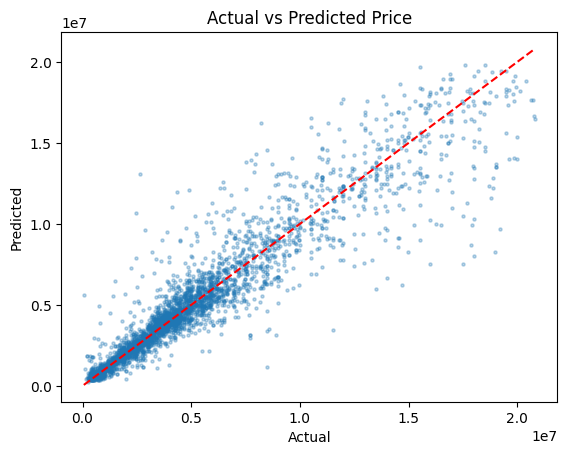

In [20]:
# Plot predictions
predictions = knn_gs.predict(test_X)

plt.scatter(test_y, predictions, alpha=0.3, s=5)
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Price')
plt.show()


## Summary

Used kNN regression with feature engineering (car age, brand popularity, fuel type flags). Test MAE around 789k LKR.

The data needed a lot of cleaning (Price, Mileage, Capacity were all strings). Feature engineering helped - adding car age and brand info improved predictions. kNN performed better than linear models, probably because there are non-linear relationships in car pricing.

**References:**
- Pipeline structure: AI1_11_regression_case_study.ipynb 
- ColumnTransformer: AI1_11_regression_case_study.ipynb 
- Custom transformer pattern (BaseEstimator, TransformerMixin): AI1_11_regression_case_study.ipynb (cell 47 - InsertRoomSize example)
- GridSearchCV: AI1_08_model_selection.ipynb and AI1_11_regression_case_study.ipynb 
- cross_validate for overfitting check: AI1_11_regression_case_study.ipynb 
- Used ChatGPT to help adapt the custom transformer for vehicle-specific features (fuel type flags, brand popularity) and debug ColumnTransformer column selection issues


## Tweak and Tune

Check for overfitting by comparing training and validation errors using `cross_validate`.


In [21]:
scores = cross_validate(linear_pipeline, dev_X, dev_y, cv=3,
                       scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1)
print("Linear Regression:")
print("  Training error:", np.mean(np.abs(scores["train_score"])))
print("  Validation error:", np.mean(np.abs(scores["test_score"])))


Linear Regression:
  Training error: 1366316.2411700187
  Validation error: 1380834.8997697646


In [22]:
scores = cross_validate(ridge_gs, dev_X, dev_y, cv=3,
                       scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1)
print("Ridge Regression:")
print("  Training error:", np.mean(np.abs(scores["train_score"])))
print("  Validation error:", np.mean(np.abs(scores["test_score"])))


Ridge Regression:
  Training error: 1366073.5891278784
  Validation error: 1379249.4353384832


In [23]:
scores = cross_validate(knn_gs, dev_X, dev_y, cv=3,
                       scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1)
print("kNN:")
print("  Training error:", np.mean(np.abs(scores["train_score"])))
print("  Validation error:", np.mean(np.abs(scores["test_score"])))


kNN:
  Training error: 565973.6314737815
  Validation error: 834325.4416724417
